In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# load medium stats
df = pd.read_csv('medium_stats.csv')
# what do we have?
df.head()

,Date,Weekday,Views,Reads,Fans
0,2019-04-18,Thursday,0,0,0
1,2019-04-19,Friday,0,0,0
2,2019-04-20,Saturday,0,0,0
3,2019-04-21,Sunday,0,0,0
4,2019-04-22,Monday,0,0,0


In [2]:
# drop columns that are not ds or y (Date, Views)
df = df.drop(['Weekday', 'Reads', 'Fans'], axis=1)

# first story released april 26th, drop dates before this
df = df.loc[(df.Date >= '2019-05-01') & (df.Date < '2019-09-01')]

df.head()

,Date,Views
13,2019-05-01,29
14,2019-05-02,130
15,2019-05-03,46
16,2019-05-04,11
17,2019-05-05,17


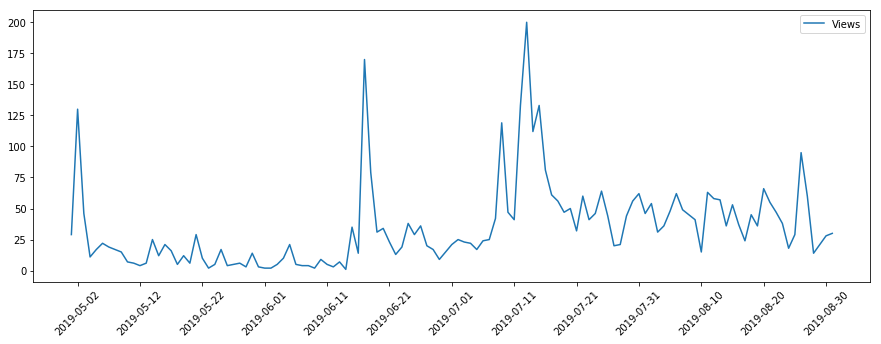

In [3]:
# examine views data
plt.figure(figsize=(15, 5))
# set x axis to every 10th date
plt.xticks(np.arange(min(df.Views), max(df.Views), 10), rotation=45)
# plot views
plt.plot(df.set_index('Date'))
# set legend
plt.legend(['Views'])
# let's see
plt.show()

In [4]:
df['Views'] = np.log(df['Views'])

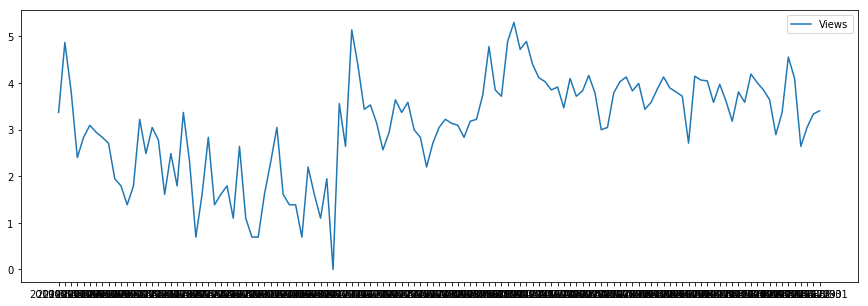

In [5]:
# examine views data
plt.figure(figsize=(15, 5))
# set x axis to every 10th date
# plt.xticks(np.arange(min(df.Views), max(df.Views), 10), rotation=45)
# plot views
plt.plot(df.set_index('Date'))
# set legend
plt.legend(['Views'])
# let's see
plt.show()

In [6]:
# rename colums for prophet
df.rename(columns={'Date': 'ds', 'Views': 'y'}, inplace=True)

df.head()

,ds,y
13,2019-05-01,3.367296
14,2019-05-02,4.867534
15,2019-05-03,3.828641
16,2019-05-04,2.397895
17,2019-05-05,2.833213


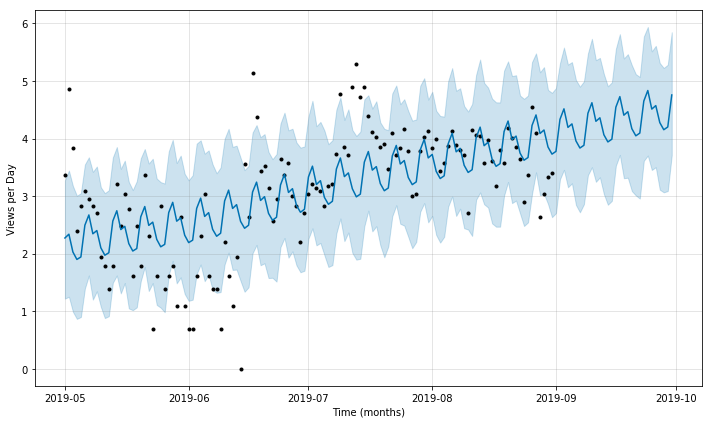

In [7]:
import fbprophet 
from fbprophet.diagnostics import cross_validation, performance_metrics

# collect dates on which a story was published
# publishing_dates = ['2019-08-26', '2019-08-10', '2019-07-30', '2019-07-12', '2019-07-10', '2019-07-09', 
#                     '2019-07-08', '2019-06-18', '2019-06-17', '2019-06-15', '2019-06-04', '2019-05-30', 
#                     '2019-05-30', '2019-05-30', '2019-05-27', '2019-05-25', '2019-05-25', '2019-05-25', 
#                     '2019-05-25', '2019-05-21', '2019-05-20', '2019-05-15', '2019-05-14', '2019-05-14', 
#                     '2019-05-05', '2019-05-02', '2019-05-01', '2019-04-26',]

# top_9_publishing_dates = ['2019-06-17', '2019-07-12', '2019-07-09',
#                           '2019-05-02', '2019-04-26', '2019-07-08', 
#                           '2019-06-04', '2019-08-26', '2019-05-30']
top_4_publishing_dates = ['2019-06-17', '2019-07-12', '2019-07-09', '2019-05-02']
top_4_subjects = ['Data Science', 'Data Science', 'N/a', 'Programming']

# 5 stories have been distributed by Medium, note those dates
dates_distributed = ['2019-05-02','2019-06-04','2019-06-17','2019-07-08','2019-07-12']
distribution_sections = ['Programming','Gaming','DS & ML','Gaming','DS & ML']

# data = {'ds':  dates_distributed,
#         'holiday': distribution_sections}
data = {'ds':  top_4_publishing_dates,
        'holiday': top_4_subjects}

distribution = pd.DataFrame(data, columns=['ds','holiday'])

# make Prophet model
prophet = fbprophet.Prophet(growth='linear',
                            changepoints=dates_distributed,
                            changepoint_prior_scale=0.1,
                            changepoint_range=0.8,
                            daily_seasonality=False,
                            weekly_seasonality=True,
                            yearly_seasonality=False,
                            holidays=distribution,
                            holidays_prior_scale=0.01)
# fit data to model
prophet.fit(df)

# make a future dataframe for 30 days
future_df = prophet.make_future_dataframe(periods=30, freq='D')

# establish predictions for that month
forecast = prophet.predict(future_df)

# isolate pred dates for September 2019
september_forecast = forecast.loc[(forecast.ds > '2019-8-31')&(forecast.ds < '2019-10-01')]

# model plot the forecase
m_plot = prophet.plot(fcst=forecast, 
                      ax=None, 
                      uncertainty=True, 
                      plot_cap=True, 
                      xlabel='Time (months)', 
                      ylabel='Views per Day')

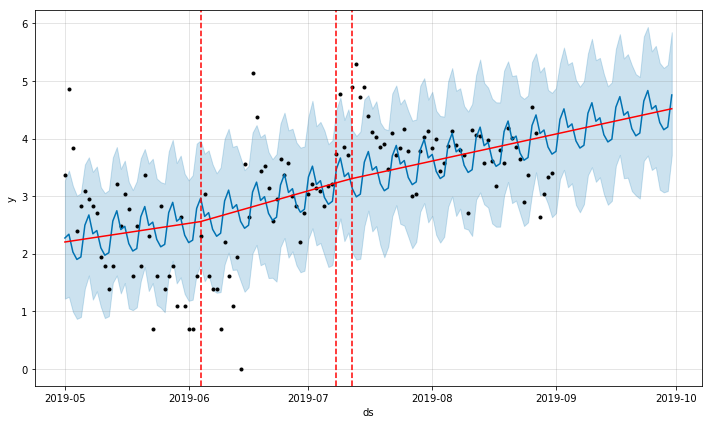

In [8]:
from fbprophet.plot import add_changepoints_to_plot
fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)

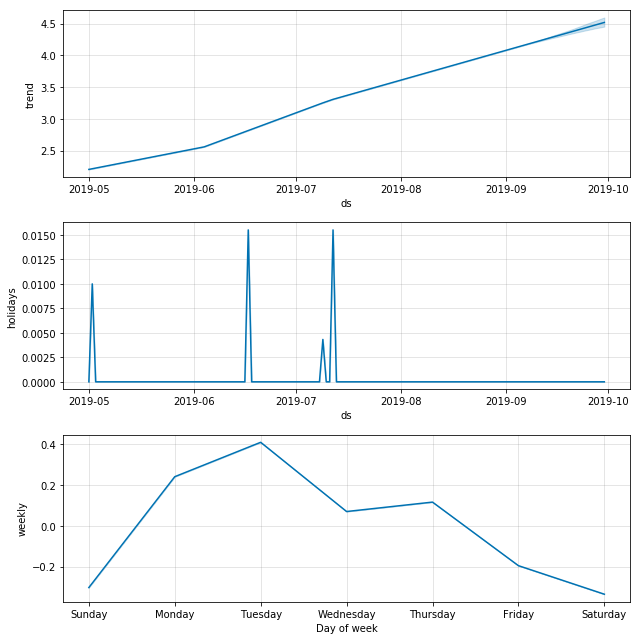

In [9]:
comps = prophet.plot_components(forecast)

In [10]:
np.exp(september_forecast.yhat.values).sum()

2294.1027149465413

In [11]:
final_day_7s = []
cv = cross_validation(prophet, initial='105 days', period='3 days', horizon='7 days')
pm = performance_metrics(cv)
final_day_7s.append(pm.tail(1).values)
pm.tail(3)

INFO:fbprophet:Making 4 forecasts with cutoffs between 2019-08-15 00:00:00 and 2019-08-24 00:00:00


,horizon,mse,rmse,mae,mape,coverage
4,5 days,0.633044,0.795640,0.642681,0.188361,0.75
5,6 days,0.640595,0.800372,0.765082,0.227458,0.75
6,7 days,1.166222,1.079918,0.956149,0.313653,0.75


In [12]:
cv = cross_validation(prophet, initial='98 days', period='3 days', horizon='7 days')
pm = performance_metrics(cv)
final_day_7s.append(pm.tail(1).values)
pm.tail(3)

INFO:fbprophet:Making 6 forecasts with cutoffs between 2019-08-09 00:00:00 and 2019-08-24 00:00:00


,horizon,mse,rmse,mae,mape,coverage
4,5 days,0.765270,0.874797,0.766680,0.225905,0.500000
5,6 days,0.525594,0.724979,0.682082,0.195590,0.833333
6,7 days,1.082290,1.040332,0.948737,0.295716,0.666667


In [13]:
cv = cross_validation(prophet, initial='84 days', period='3 days', horizon='7 days')
pm = performance_metrics(cv)
final_day_7s.append(pm.tail(1).values)
pm.tail(3)

INFO:fbprophet:Making 11 forecasts with cutoffs between 2019-07-25 00:00:00 and 2019-08-24 00:00:00


,horizon,mse,rmse,mae,mape,coverage
4,5 days,0.643714,0.802318,0.691343,0.192972,0.727273
5,6 days,0.527757,0.726469,0.698612,0.191549,0.909091
6,7 days,1.086653,1.042426,0.965775,0.293896,0.636364


In [15]:
cv = cross_validation(prophet, initial='70 days', period='3 days', horizon='7 days')
pm = performance_metrics(cv)
final_day_7s.append(pm.tail(1).values)
pm.tail(3)

INFO:fbprophet:Making 16 forecasts with cutoffs between 2019-07-10 00:00:00 and 2019-08-24 00:00:00


,horizon,mse,rmse,mae,mape,coverage
4,5 days,0.707892,0.841363,0.740780,0.206329,0.875
5,6 days,0.517316,0.719247,0.652838,0.180401,0.875
6,7 days,0.981270,0.990591,0.883338,0.260225,0.625


In [34]:
cv = cross_validation(prophet, initial='56 days', period='7 days', horizon='14 days')
pm = performance_metrics(cv)
final_day_7s.append(pm.tail(1).values)
pm.tail(3)

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-06-29 00:00:00 and 2019-08-17 00:00:00


,horizon,mse,rmse,mae,mape,coverage
10,12 days,0.979874,0.989886,0.847086,0.236375,0.625000
11,13 days,0.893066,0.945022,0.865351,0.226427,0.806818
12,14 days,1.783619,1.335522,1.235357,0.362608,0.420455


In [19]:
cv = cross_validation(prophet, initial='49 days', period='3 days', horizon='7 days')
pm = performance_metrics(cv)
final_day_7s.append(pm.tail(1).values)
pm.tail(3)

INFO:fbprophet:Making 23 forecasts with cutoffs between 2019-06-19 00:00:00 and 2019-08-24 00:00:00


,horizon,mse,rmse,mae,mape,coverage
4,5 days,0.789777,0.888694,0.734565,0.197110,0.782609
5,6 days,0.628622,0.792857,0.682366,0.185972,0.869565
6,7 days,0.923261,0.960865,0.807847,0.233823,0.652174


In [35]:
cv = cross_validation(prophet, initial='42 days', period='7 days', horizon='14 days')
pm = performance_metrics(cv)
final_day_7s.append(pm.tail(1).values)
pm.tail(3)

INFO:fbprophet:Making 10 forecasts with cutoffs between 2019-06-15 00:00:00 and 2019-08-17 00:00:00


,horizon,mse,rmse,mae,mape,coverage
10,12 days,1.254321,1.119965,0.899172,0.258866,0.600000
11,13 days,1.257271,1.121281,0.948153,0.270587,0.742857
12,14 days,1.788702,1.337424,1.216179,0.380364,0.442857


In [40]:
cv = cross_validation(prophet, initial='30 days', period='14 days', horizon='30 days')
pm = performance_metrics(cv)
final_day_7s.append(pm.tail(1).values)
pm.tail(3)

INFO:fbprophet:Making 5 forecasts with cutoffs between 2019-06-06 00:00:00 and 2019-08-01 00:00:00
INFO:fbprophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,coverage
25,28 days,4.739634,2.177070,2.002830,0.2
26,29 days,5.094272,2.257049,2.045022,0.2
27,30 days,5.400545,2.323907,2.099141,0.2


In [37]:
def lowdex(llist):
    for i in range(len(llist)):
        if i == 0:
            low = llist[i][0][4]
            n = i
        else:
            if llist[i][0][4] < low:
                prior, m = low, n
                low = llist[i][0][4]
                n = i
    return [n, low],[prior, m]

sevens = lowdex(final_day_7s)
# thirtys = lowdex(final_day_30s)

In [38]:
sevens[0][0], sevens[0][1]

(4, 0.23191023710318115)

In [29]:
# thirtys[0][0], thirtys[0][1]

(6, 0.2)

In [39]:
sevens[1][1], sevens[1][0]

(3, 0.26022473352788844)

In [31]:
# thirtys[1][1], thirtys[1][0]

(2, 0.4589697828899634)

In [32]:
# if len(final_day_30s[5][0]) == len(final_day_7s[4][0]) == len(final_day_30s[3][0]):
#     print(len(final_day_7s[2][0]))
# else:
#     raise Exception('ERROR')

6


In [33]:
s7um = 0
# s6um = 0
for i in range (len(final_day_7s)):
    s7um += final_day_7s[i][0][4]
    # s6um += final_day_30s[i][0][4]
print(s7um)
# print(s6um)

2.2692224004393338
3.436396071444231
